In [28]:
#importing relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import clhs as cl
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
#dictionary with parish names as keys and device ids as values
parish_sensor_dict = {'NTINDA':930434, 'BUGOLOBI':718028, 'NANTABULIRWA':912224, 'KIREKA':930426, 'LUWAFU':930427, 
                     'BANDA':912223, 'MBUYA II':912222, 'NAKASERO II':912220, 'KIWATULE':870145, 'KYALIWAJJALA':870143,
                     'BUTABIKA':870144, 'NANSANA WEST':870147, 'NANSANA EAST':870142, 'BUSEGA':870139, 'KYANJA':832255,
                     'BUSABALA':832252, 'BUNAMWAYA':832253, 'KYEBANDO':832254, 'LUKULI':832251, 'BUKOTO I':782720,
                     'KANSANGA':782719, 'KASUBI':782718, 'NAGURU II':755614, 'MAKINDYE I':755612,
                     'MAKERERE UNIVERSITY':870146, 'LUBAGA':737276, 'BWEYOGERERE':737273, 'CIVIC CENTRE':689761}

In [34]:
def preprocessing(parish):
    '''
    Collects and preprocesses data
    '''
    channel_id = parish_sensor_dict[parish]
    
    #credentials to access GCP
    credentials = service_account.Credentials.from_service_account_file('C:/Users/User/AirQo-d982995f6dd8.json')
    project_id = 'airqo-250220'

    #creating a bigquery cliennt
    bqclient = bigquery.Client(credentials= credentials, project=project_id)
    
    query_string = "SELECT created_at, pm2_5 FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id = %d" %channel_id    
    bqdata = bqclient.query(query_string).result()
    data= bqdata.to_dataframe()
    
    data = data.sort_values(by = 'created_at', ascending=True)
    
    #filepath = r'D:/AirQo/sensor location model/feeds/'+str(channel_id)+'.csv'
    #cols = ['created_at', 'field1']
    #data = pd.read_csv(filepath,  parse_dates = ['created_at'], usecols=cols)
    
    data.set_index('created_at', inplace=True)
    hourly_data = data.resample('H').mean().round(2)  
    final_data=hourly_data.dropna()
    
    name = parish+'_pm2_5'
    final_data.rename(columns = {'pm2_5': name}, inplace = True)
    print (parish, ':done')
    
    return final_data

In [35]:
def merge_dfs(df_list):
    '''
    Merges several dataframes into one based on the index
    '''
    from functools import reduce
    final_df = reduce(lambda left,right: pd.merge(left,right,on='created_at'), df_list)
    return final_df

In [36]:
def find_correlation(data, column1, column2):
    '''
    Finds the correlation between 2 different columns in a dataframe
    '''
    correlation = data[column1].corr(data[column2])
    return correlation

In [37]:
def correlation_matrix_1(df):
    return df.corr()

In [38]:
def correlation_matrix_2(df):
    import seaborn as sns
    
    plt.figure(figsize=(5,5))
    sns.heatmap(correlation_matrix_1(df), annot=True, cmap=plt.cm.Reds)
    plt.show()

In [39]:
def correlation_matrix_3(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(correlation_matrix_1(df), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Matrix')
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

In [40]:
def correlation_matrix_4(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    f = plt.figure(figsize=(5,5))
    plt.matshow(correlation_matrix_1(df), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)

In [ ]:
X = data[['light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km', 
          'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
          'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 
          'hhs_density', 'T123_per_sqkm']]

In [61]:
sampled = cl.clhs(X, 5, max_iterations=1000)
sampled

cLHS:100%|██████████████████████████████████████████|1000/1000 [Elapsed time: 1.4990003108978271, ETA: 0.0, 667.11it/s]


{'sample_indices': array([23, 12, 13, 16, 18]),
 'remaining_indices': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 17, 19, 20,
        21, 22, 24, 25, 26, 27]),
 'x':     light_par_tadooba_per_km  light_firewood_per_km  light_cow_dung_per_km  \
 23                     36.11                   0.35                   0.00   
 12                     29.37                   0.30                   0.00   
 13                      6.42                   0.00                   0.00   
 16                     44.58                   2.22                   0.05   
 18                     85.12                   5.27                   0.00   
 
     light_grass_per_km  cook_charc_per_km  cook_firewood_per_km  \
 23                0.00            1162.22                 69.08   
 12                0.00            1333.71                 45.40   
 13                0.00             116.76                 11.55   
 16                0.43             365.51                 59.94   


In [62]:
clhs_samples =data.iloc[sampled['sample_indices']]
clhs_samples.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster,average pm2_5,category
23,WAKISO,BUNAMWAYA DIVISION,BUNAMWAYA,32549,8293,29.4,32.555615,0.255076,5.732152,5.683044,...,0.27,0.19,"POLYGON((32.5454103015193 0.240370313949034, 3...",POINT(32.5556147202207 0.25507614594765),0.404357,0.879108,0.252319,7,78.324790,Unhealthy
12,KAMPALA,RUBAGA DIVISION,LUBAGA,22344,5903,37.6,32.550562,0.299000,3.370291,3.341475,...,0.29,0.22,"POLYGON((32.557895773912 0.304724246525028, 32...",POINT(32.5505620887704 0.298999749317155),0.403719,0.866166,0.294564,7,70.769064,Unhealthy
13,KAMPALA,CENTRAL DIVISION,NAKASERO II,1795,537,25.3,32.579202,0.323343,1.558766,1.545287,...,2.01,1.15,"POLYGON((32.5776860513665 0.315082252470744, 3...",POINT(32.5792020679346 0.323343298883222),0.375796,0.870529,0.317738,0,41.588850,Unhealthy for Sensitive Groups
16,WAKISO,MASAJJA DIVISION,BUSABALA,39045,9642,22.1,32.608197,0.220525,21.154149,20.969131,...,0.42,0.37,"POLYGON((32.5788473452533 0.255990460622366, 3...",POINT(32.6081969296703 0.220524805457365),0.360602,0.906708,0.218742,5,45.764890,Unhealthy for Sensitive Groups
18,WAKISO,NANSANA DIVISION,NANSANA EAST,27768,6898,29.1,32.530586,0.367282,2.654985,2.632465,...,0.22,0.13,"POLYGON((32.5331574923712 0.372837835675488, 3...",POINT(32.5305858106101 0.367282136283768),0.411106,0.837886,0.359080,4,78.287078,Unhealthy


In [73]:
def clhs_sampling(X, data, sensor_number):
    sampled = cl.clhs(X, sensor_number, max_iterations=1000)    
    clhs_samples =data.iloc[sampled['sample_indices']]
    
    clhs_df_list = []
    for parish in clhs_samples.parish:
        data = preprocessing(parish)
        clhs_df_list.append(data)
        
    merged_df = merge_dfs(clhs_df_list)
    #correlation_matrix_1(merged_df)
    correlation_matrix_2(merged_df)
    #correlation_matrix_3(merged_df)
    #correlation_matrix_4(merged_df)
    

In [70]:
data = pd.read_csv('gp_data.csv')
data.shape

(28, 50)

##### using all data features

cLHS:100%|███████████████████████████████████████████|1000/1000 [Elapsed time: 14.526994228363037, ETA: 0.0, 68.84it/s]


NAKASERO II :done
BUKOTO I :done
KYALIWAJJALA :done
BUNAMWAYA :done
NANSANA EAST :done


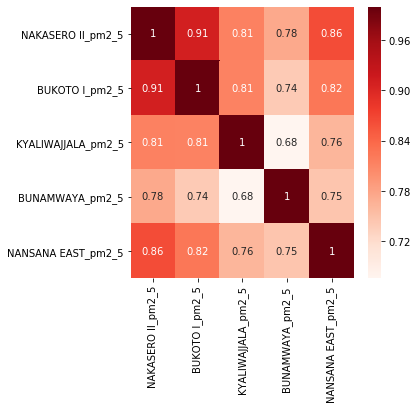

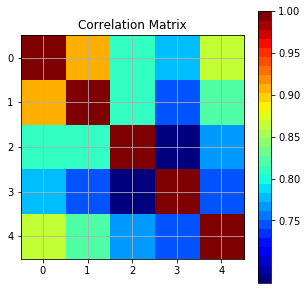

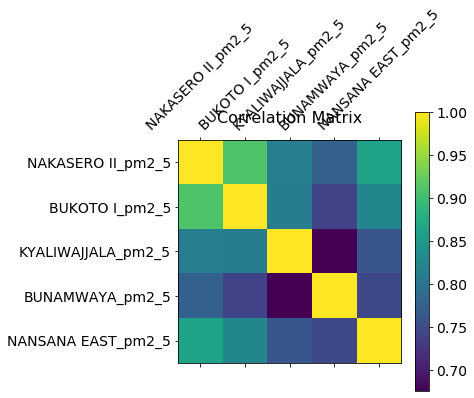

In [74]:
clhs_sampling(data, data, 5)

##### using most features


cLHS:100%|██████████████████████████████████████████|1000/1000 [Elapsed time: 1.5180315971374512, ETA: 0.0, 658.75it/s]


KANSANGA :done
CIVIC CENTRE :done
NANSANA WEST :done
LUKULI :done
BUNAMWAYA :done


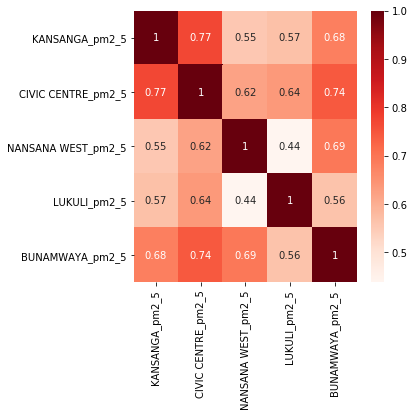

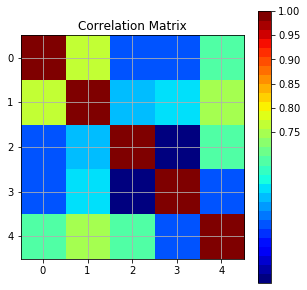

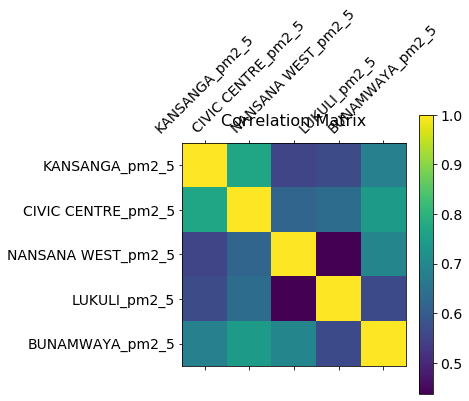

In [75]:
most = data[['light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km', 
          'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
          'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 
          'hhs_density', 'T123_per_sqkm']]
clhs_sampling(most, data, 5)

##### using 8 features

cLHS:100%|██████████████████████████████████████████|1000/1000 [Elapsed time: 1.3210008144378662, ETA: 0.0, 757.00it/s]


LUKULI :done
NANSANA EAST :done
BUNAMWAYA :done
CIVIC CENTRE :done
KASUBI :done


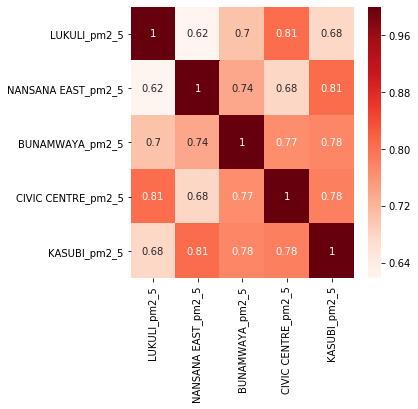

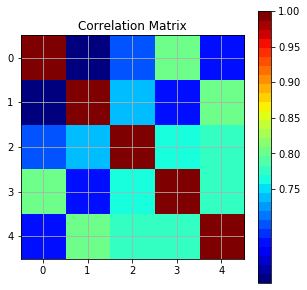

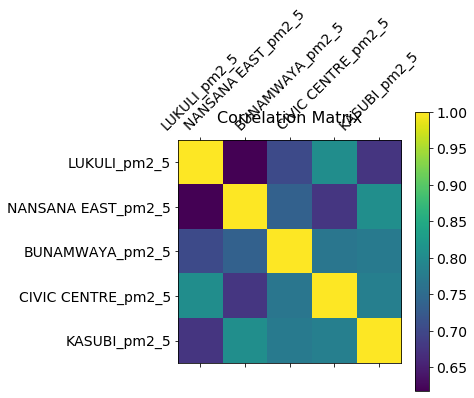

In [76]:
eight_features = data[['cook_charc_per_km', 'cook_firewood_per_km', 'waste_burn_per_km', 'kitch_outside_built_per_km', 
             'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 'hhs_density']]

clhs_sampling(eight_features, data, 5)

###### using six features

cLHS:100%|██████████████████████████████████████████|1000/1000 [Elapsed time: 1.3410146236419678, ETA: 0.0, 745.70it/s]


BUTABIKA :done
KASUBI :done
NANSANA EAST :done
NAKASERO II :done
KIWATULE :done


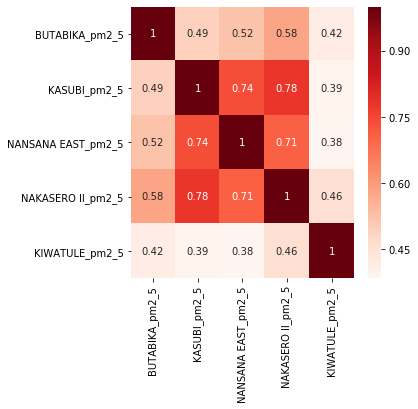

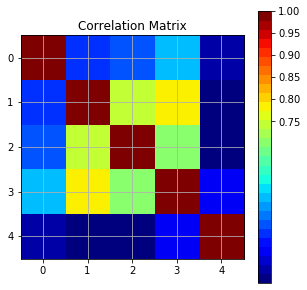

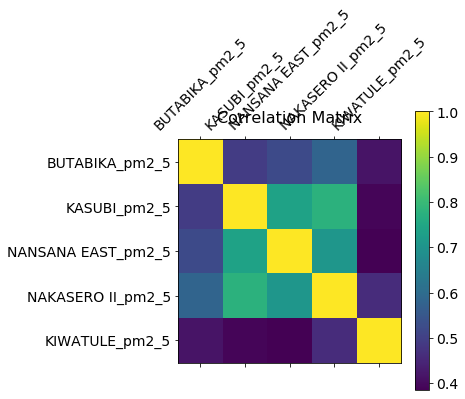

In [77]:
six_features = data[['cook_charc_per_km', 'cook_firewood_per_km', 'waste_burn_per_km', 'kitch_outside_built_per_km', 
             'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 'hhs_density']]

clhs_sampling(six_features, data, 5)